In [1]:
'''
The purpose of this analysis is to accurately predict the duration of taxi trips in New York City. This work is for a Kaggle competition. To make our predictions, we will use a feed-forward neural network using TensorFlow, a RandomForest Regressor, Lightgbm, and Catboost. Random search will be used to find the optimal network architecture and hyperparameter values for each model.

The sections of this analysis are:

Loading the Data
Cleaning the Data
Building the Neural Network
Training the Neural Network
Training the Other Models
Making Predictions
Summary
'''

'\nThe purpose of this analysis is to accurately predict the duration of taxi trips in New York City. This work is for a Kaggle competition. To make our predictions, we will use a feed-forward neural network using TensorFlow, a RandomForest Regressor, Lightgbm, and Catboost. Random search will be used to find the optimal network architecture and hyperparameter values for each model.\n\nThe sections of this analysis are:\n\nLoading the Data\nCleaning the Data\nBuilding the Neural Network\nTraining the Neural Network\nTraining the Other Models\nMaking Predictions\nSummary\n'

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf 
from sklearn.ensemble import RandomForestRegressor as RFR
import lightgbm as lgb
from catboost import CatBoostRegressor

from collections import namedtuple
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

import time
import operator
import haversine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12

print(tf.__version__)

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


1.11.0


In [3]:
# Where to save the figures
import os
PROJECT_ROOT_DIR = "."
if os.path.isdir("image"):
    os.mkdir("image")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "image")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [21]:
#Extract zip file
!ls data
import zipfile
def extract(files):
    for file in files:
        path = os.path.join("data", file)
        zip_ref = zipfile.ZipFile(path, 'r')
        print(zip_ref)
        zip_ref.extractall('data/' + file.split(".")[0])
        zip_ref.close()
        os.remove(path)

extract(['sample_submission.zip', 'test.zip', 'train.zip'])

sample_submission  test  train


FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_submission.zip'

In [4]:
# Loading data
train = pd.read_csv('data/train/train.csv')
test = pd.read_csv('data/test/test.csv')

In [5]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [8]:
#Data summary
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [9]:
#A minimum of 1 second, and a maximum of 3 526 282 seconds (roughly 980 hours). No way someone took a trip that long, the bill would be astronomical. And a 1 second trip won't get you anywhere. So clearly there are some outliers we need to deal with.
#As a final way of looking at the data initially, consider the use of Pandas' `info` function. The advantage of using this particular function is getting an almost combined view of `describe` and `head`/`tail`, together with `shape` (which describes the number of rows and columns in the particular file). More on the use and output of `info` [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html "Pandas info").

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
#Data Preparation
'''
As we noted earlier there are some outliers associated 
with the `trip_duration` variable, specifically a 980 
hour maximum trip duration and a minimum of 1 second 
trip duration. I've decided to exclude data that lies
outside 2 standard deviations from the mean. It might
be worthwhile looking into what effect excluding up 
to 4 standard deviations would have on the end-results.
'''

"\nAs we noted earlier there are some outliers associated \nwith the `trip_duration` variable, specifically a 980 \nhour maximum trip duration and a minimum of 1 second \ntrip duration. I've decided to exclude data that lies\noutside 2 standard deviations from the mean. It might\nbe worthwhile looking into what effect excluding up \nto 4 standard deviations would have on the end-results.\n"

In [12]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [13]:
#Latitude and Longitude Clean-up
#Real boder of ny city
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [14]:
#Data Clean-up
# As a final step in preparing our data we need to change the formatting
# of the date variables (`pickup_datetime` and `dropoff_datetime`). 
# This will help a lot with data extraction in the coming section.

In [15]:
# train['pickup_datetime'].dt

In [16]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

In [17]:
train['trip_duration'][:5].values

array([ 455,  663, 2124,  429,  435])

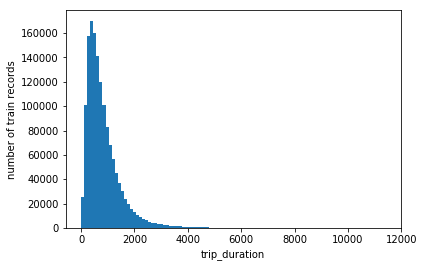

In [18]:
#Data Visualisation and Analysis
'''
These next steps involve looking at the data visually.
Often you'll discover looking at something significant
as a graph rather than a table (for example) will give 
you far greater insight into its nature and what you 
might need to do to work with it. Of course, the opposite 
could also be considered true, so don't neglect the first 
section we went through.
'''

#Initial Analysis
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

In [19]:
'''
This is a good opportunity to play with some data transformations
to see if notable patterns emerge in the data when applying 
certain transforms, for example a log transform. In this case
, applying a log transformation to the trip duration makes 
sense, since we are doing this to accommodate 
the leaderboard's scoring metric. That would look like this:
'''

"\nThis is a good opportunity to play with some data transformations\nto see if notable patterns emerge in the data when applying \ncertain transforms, for example a log transform. In this case\n, applying a log transformation to the trip duration makes \nsense, since we are doing this to accommodate \nthe leaderboard's scoring metric. That would look like this:\n"

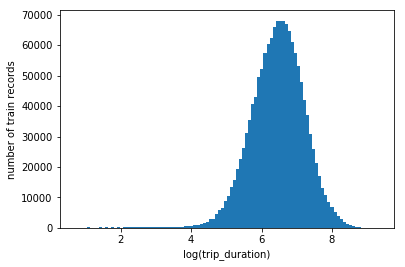

/home/tuanhle/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


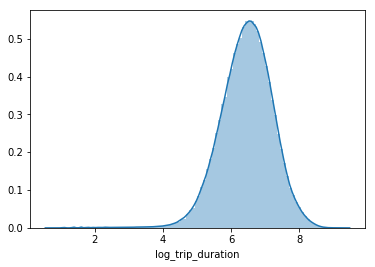

In [20]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

In [21]:
'''One might also be interested to view the number of trips over time, since this could reveal not only apparent seasonality in the data and certain trends, but could point out any siginficant outliers (if not already cleaned out of the data set of course) and indicate missing values (again, only if it wasn't already checked and cleaned in the data set).

For this we'll simply plot a timeseries line graph of both the 
test and training data to not only look into identifying possible 
trends/seasonality but to see if both data sets follow the same pattern shape. Reasonably we'd expect the two datasets to follow a very similar shape since the test data would be/is a randomly selected sample from the original dataset containing all data points. By picking the test points randomly, each data point has the same likelihood of being picked as 
a test point, thus ensuring uniformity in the test data sample.'''

"One might also be interested to view the number of trips over time, since this could reveal not only apparent seasonality in the data and certain trends, but could point out any siginficant outliers (if not already cleaned out of the data set of course) and indicate missing values (again, only if it wasn't already checked and cleaned in the data set).\n\nFor this we'll simply plot a timeseries line graph of both the \ntest and training data to not only look into identifying possible \ntrends/seasonality but to see if both data sets follow the same pattern shape. Reasonably we'd expect the two datasets to follow a very similar shape since the test data would be/is a randomly selected sample from the original dataset containing all data points. By picking the test points randomly, each data point has the same likelihood of being picked as \na test point, thus ensuring uniformity in the test data sample."

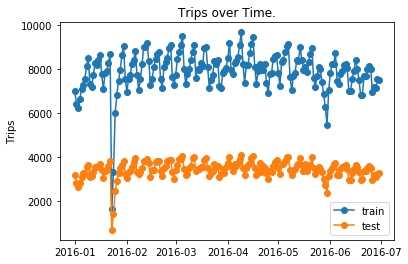

In [22]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

In [23]:
'''
Clearly the test and train datasets follow a very simila shape, as expected. A couple of points stand out at first glance. Around late-Jan/early-Feb there is a massive drop in the number of trips taken. A slightly less drastic drop is apparent about four months later. The first drop could be related to the season: it's winter in New York so you'd expect less trips being taken (who wants to ride around when it's near freezing outside?). However, this seems unlikely because the dip looks to be isolated around a single day or couple of days. In my opinion there's a greater chance that there were strikes (if you've got the South African mindset I do, but this is New York, so probably not that) or that there was an issue with the data system recording the trips. Whatever the reason, it's worth noting these 'outliers'.

Let's see how significantly (or not significantly at all) the two vendors differ in their respective mean trip durations:


'''

"\nClearly the test and train datasets follow a very simila shape, as expected. A couple of points stand out at first glance. Around late-Jan/early-Feb there is a massive drop in the number of trips taken. A slightly less drastic drop is apparent about four months later. The first drop could be related to the season: it's winter in New York so you'd expect less trips being taken (who wants to ride around when it's near freezing outside?). However, this seems unlikely because the dip looks to be isolated around a single day or couple of days. In my opinion there's a greater chance that there were strikes (if you've got the South African mindset I do, but this is New York, so probably not that) or that there was an issue with the data system recording the trips. Whatever the reason, it's worth noting these 'outliers'.\n\nLet's see how significantly (or not significantly at all) the two vendors differ in their respective mean trip durations:\n\n\n"

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

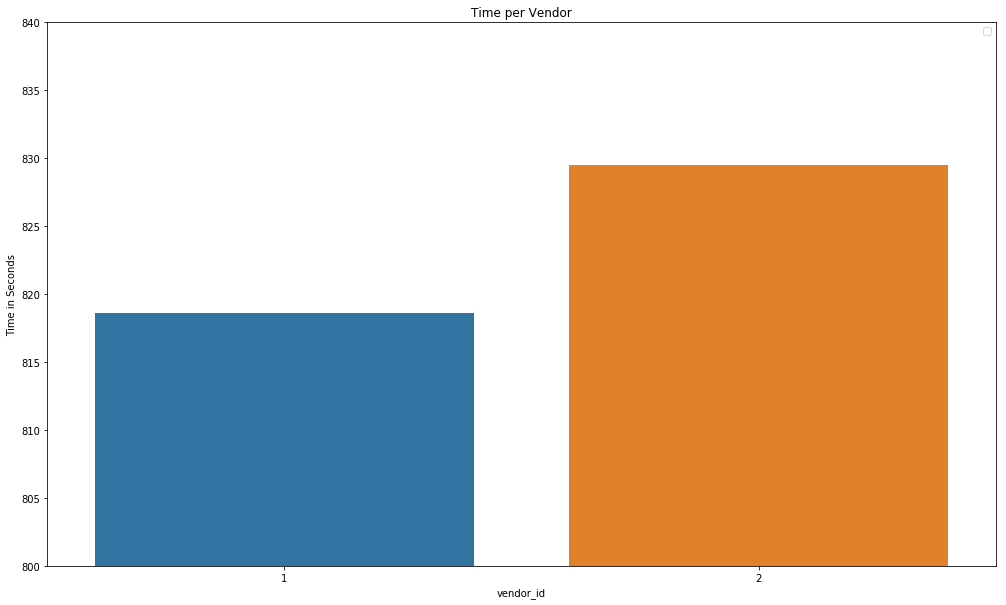

In [24]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

In [25]:
'''
So it doesn't look like there's much of a difference between travel times for the two vendors. One would assume that knowing which routes are the fastest to take from A to B is no secret, and that it is more a trick of the trade, rather than IP. But something doesn't look right, so there's another feature we can use to see if after all there is a significant difference in mean travel time: the `store_and_fwd_flag`.
'''

"\nSo it doesn't look like there's much of a difference between travel times for the two vendors. One would assume that knowing which routes are the fastest to take from A to B is no secret, and that it is more a trick of the trade, rather than IP. But something doesn't look right, so there's another feature we can use to see if after all there is a significant difference in mean travel time: the `store_and_fwd_flag`.\n"

No handles with labels found to put in legend.


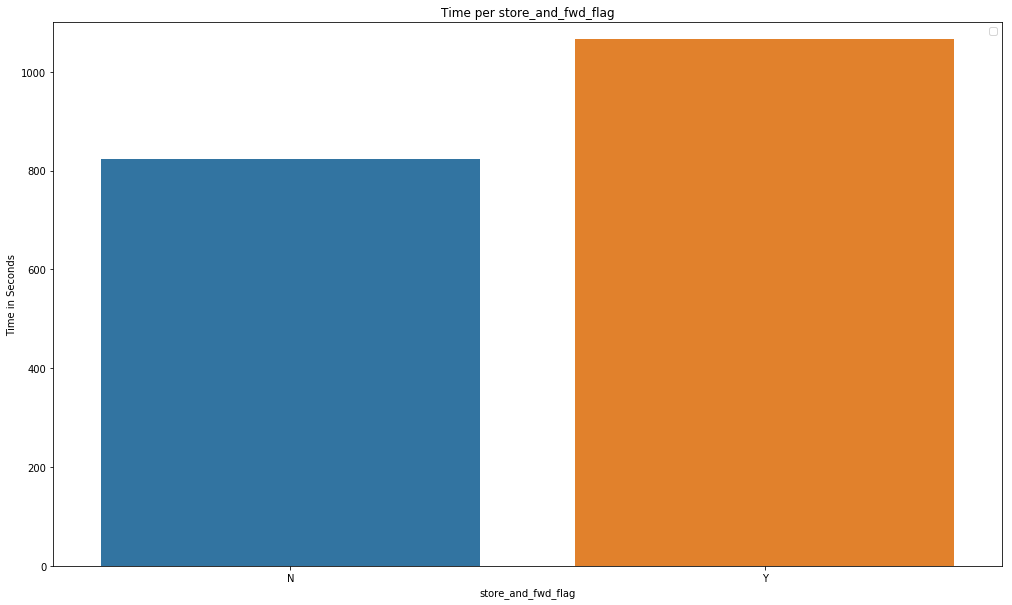

In [26]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

In [27]:

'''So it would seem that the `store_and_fwd_flag` discriminates well between travel times. Clearly there is a slight skew in the data where some of the vendor employees didn't record their travel times accurately.
As mentioned earlier when digging into the variables, I thought about the impact that the number of passengers per trip might have on travel time. The thought process was that more passengers might equal more stops, 
hence prolonging the travel time from start to finish (unless the different drop-offs were recorded as separate trips). So in order to find out if there is infact a significant influence in travel time, let's group 
the mean travel times by the `passenger_count`:'''

"So it would seem that the `store_and_fwd_flag` discriminates well between travel times. Clearly there is a slight skew in the data where some of the vendor employees didn't record their travel times accurately.\nAs mentioned earlier when digging into the variables, I thought about the impact that the number of passengers per trip might have on travel time. The thought process was that more passengers might equal more stops, \nhence prolonging the travel time from start to finish (unless the different drop-offs were recorded as separate trips). So in order to find out if there is infact a significant influence in travel time, let's group \nthe mean travel times by the `passenger_count`:"

No handles with labels found to put in legend.


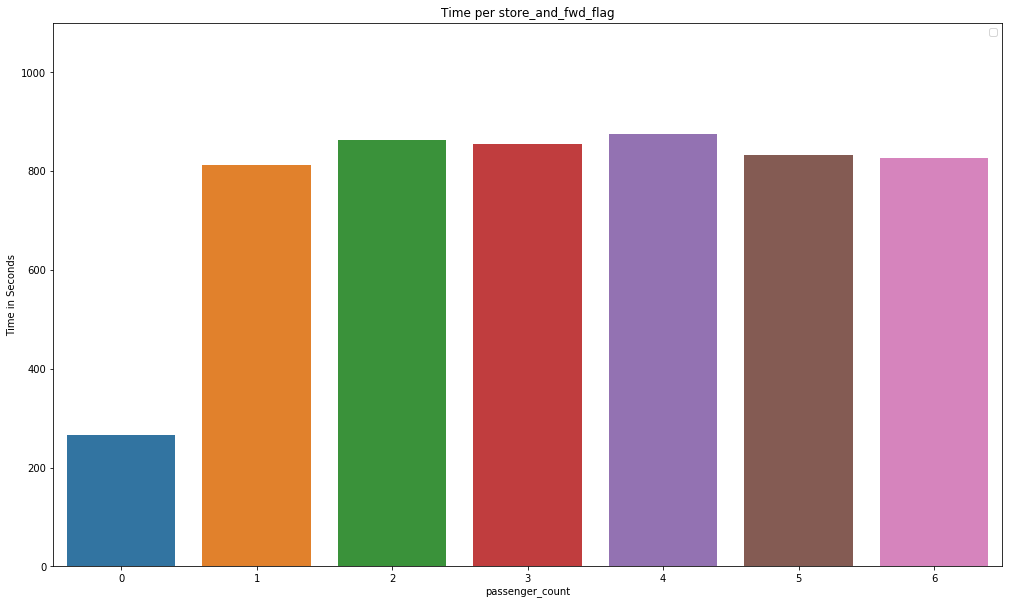

In [28]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [29]:
'''
So no significant difference evident that could be explained by the number of passengers in the vehicle for any given trip. It is interesting to note that there is are on average +-4min trips associated with no passengers. This is probably a mistake made in recording the data unless the vendor employee is into charging him/herself for trips whilst on the job.

Again, we need to check whether the test and train data matches with respect to the number of trips containing X-number of passengers:
'''

'\nSo no significant difference evident that could be explained by the number of passengers in the vehicle for any given trip. It is interesting to note that there is are on average +-4min trips associated with no passengers. This is probably a mistake made in recording the data unless the vendor employee is into charging him/herself for trips whilst on the job.\n\nAgain, we need to check whether the test and train data matches with respect to the number of trips containing X-number of passengers:\n'

In [30]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [31]:
test.groupby('passenger_count').size()


passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

In [32]:
'''
At first glance nothing seems too far out of the ordinary, however we can note that the passenger count is not ordinal. Note the two extra trips with 9 passengers in the test data. Again, it would seem there is some outlier data we haven't dealt with yet. Other than that though, the counts do seem to match relatively between the two data sets. The next step is to dive into the latitude and longitude data provided, trying to visualise the routes taken and potentially creating a map view to get a feel for the spacial components associated with the data.
'''

"\nAt first glance nothing seems too far out of the ordinary, however we can note that the passenger count is not ordinal. Note the two extra trips with 9 passengers in the test data. Again, it would seem there is some outlier data we haven't dealt with yet. Other than that though, the counts do seem to match relatively between the two data sets. The next step is to dive into the latitude and longitude data provided, trying to visualise the routes taken and potentially creating a map view to get a feel for the spacial components associated with the data.\n"

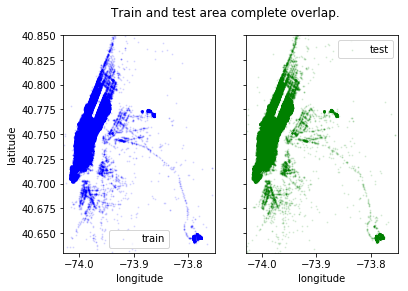

In [33]:
#3.2 Coordinate Mapping
#Just like we compared the travel time data and the number of passengers between the test and train sets, we can try and verify that the pickup location data in
#both sets are fairly similar and representative of one another.
#3.2.1 Pickup Locations
'''
To do this, we utilise the city map border coordinates for New York, mentioned earlier in the kernel to create the canvas wherein the coordinate points will be graphed. To display the actual coordinates a simple scatter plot is used:
'''
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [52]:
We can tell from the two graphs that the pickup locations 
are quite similar, with the notable difference being that the train 
data set simply has more data points (which makes sense).

SyntaxError: invalid syntax (<ipython-input-52-f4e3a40604ef>, line 1)

In [34]:
# Feature Extraction
# PCA
# We use PCA to transform longitude and latitude coordinates.
# In this case it is not about dimension reduction since we 
# transform 2D-> 2D. The rotation could help for decision 
# tree splits.
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

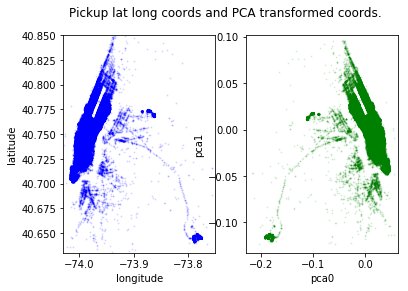

In [36]:
fig, ax = plt.subplots(ncols=2)
N = 100000
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()


In [37]:
# 3.2.2 Distance and Directionality
#This next part is quite interesting. 
#Thanks to Beluga's post, we can determine 
#the distance and direction of a specific 
#trip based on the pickup and dropoff coordinates. 
#For this I've made three functions, as:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [38]:
'''
Applying these functions to both the test and train data, we can 
calculate the haversine distance which is the great-circle distance
between two points on a sphere given their longitudes and latitudes
. We can then calculate the summed distance traveled in Manhattan. 
And finally we calculate (through some handy trigonometry) the 
direction (or bearing) of the distance traveled. These calculations 
are stored as variables in the separate data sets. The next step 
I decided to take is to create neighourhods, 
like Soho, or the Upper East Side, from the data and display this.
'''

'\nApplying these functions to both the test and train data, we can \ncalculate the haversine distance which is the great-circle distance\nbetween two points on a sphere given their longitudes and latitudes\n. We can then calculate the summed distance traveled in Manhattan. \nAnd finally we calculate (through some handy trigonometry) the \ndirection (or bearing) of the distance traveled. These calculations \nare stored as variables in the separate data sets. The next step \nI decided to take is to create neighourhods, \nlike Soho, or the Upper East Side, from the data and display this.\n'

In [39]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [40]:
#3.3.3 Lets create the "Neighborhoods"
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [41]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [42]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

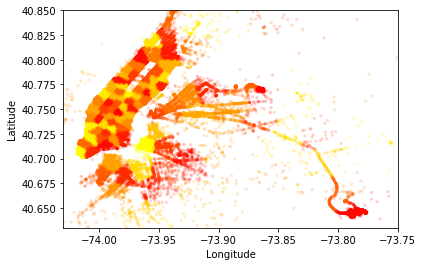

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [44]:
#3.4 Date Extraction
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [45]:
train.groupby('Month').size(),test.groupby('Month').size()


(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [46]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [47]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [48]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())


(7, 7)

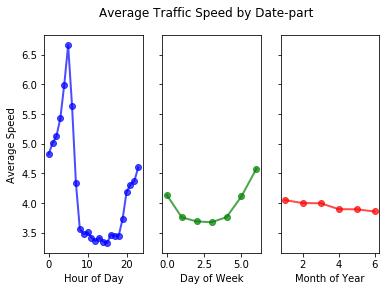

In [49]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [50]:
'''
So the interesting thing to notice here is the average speed by hour of day. We're I'm from traffic usually peaks between 5am and 9am, and then again from about 4pm to around 6 or 7pm. But it would seem in manhattan that average speed diminishes as the day goes by from around 6am and picks up again around 7 or 8pm. So most of the travelling in the Big Apple happens during work hours. The average speed by weekday follows an expected trend. Over the weekend (Friday, Saturday, Sunday) the average speed picks up quite nicely, indicating less traffic. Finally, the average trip speed by month follows an expected trend. In the winter months there are less trips (see the previous timeseries plot we made) indicating less traffic in general in the city which means you can average a higher speed on the roads.
'''

"\nSo the interesting thing to notice here is the average speed by hour of day. We're I'm from traffic usually peaks between 5am and 9am, and then again from about 4pm to around 6 or 7pm. But it would seem in manhattan that average speed diminishes as the day goes by from around 6am and picks up again around 7 or 8pm. So most of the travelling in the Big Apple happens during work hours. The average speed by weekday follows an expected trend. Over the weekend (Friday, Saturday, Sunday) the average speed picks up quite nicely, indicating less traffic. Finally, the average trip speed by month follows an expected trend. In the winter months there are less trips (see the previous timeseries plot we made) indicating less traffic in general in the city which means you can average a higher speed on the roads.\n"

In [51]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,Month,DayofMonth,Hour,dayofweek,avg_speed_h,avg_speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,1.735,99.970,38,44,3,14,17,0,3.293,3.814
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,2.431,-117.154,72,48,6,12,0,6,2.723,3.666
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,8.204,-159.680,97,16,1,19,11,1,3.006,3.862
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,1.661,-172.738,95,98,4,6,19,2,3.463,3.873
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,1.199,179.474,45,23,3,26,13,5,2.732,2.757


In [52]:
train.groupby('dayofweek').mean()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,pickup_pca0,pickup_pca1,...,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,Month,DayofMonth,Hour,avg_speed_h,avg_speed_m
dayofweek,,,,,,,,,,,,,,,,,,,,,
0,1.534,1.633,-73.971,40.752,-73.973,40.752,798.020,6.411,-0.003,0.000,...,3.420,4.432,-17.113,47.489,48.653,3.514,15.443,13.980,4.137,5.354
1,1.536,1.635,-73.973,40.752,-73.974,40.753,843.276,6.476,-0.001,0.001,...,3.204,4.140,-17.006,48.085,49.065,3.552,15.392,14.103,3.761,4.863
2,1.533,1.633,-73.974,40.752,-73.974,40.753,867.643,6.499,0.000,0.001,...,3.202,4.141,-16.441,48.240,48.881,3.577,15.262,14.060,3.693,4.777
3,1.533,1.639,-73.974,40.752,-73.973,40.752,883.966,6.512,0.000,0.000,...,3.269,4.227,-16.041,48.321,48.809,3.574,16.201,14.077,3.679,4.757
4,1.532,1.662,-73.974,40.751,-73.973,40.752,853.675,6.482,0.001,-0.000,...,3.254,4.210,-15.568,48.351,48.839,3.414,15.001,13.665,3.764,4.870
5,1.534,1.729,-73.977,40.749,-73.975,40.750,766.708,6.400,0.003,-0.002,...,3.188,4.123,-14.533,49.074,49.268,3.486,15.679,13.169,4.114,5.323
6,1.538,1.717,-73.974,40.749,-73.972,40.750,748.615,6.356,0.000,-0.002,...,3.555,4.598,-13.036,48.039,48.633,3.500,15.525,12.212,4.579,5.920


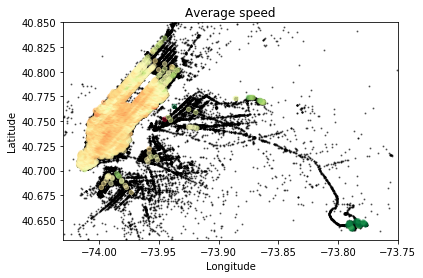

In [53]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [54]:
#4. Data Enrichment & Dummy Variables
#4.1 Data Enrichment
# For this particular problem we can add OSRM ([Open Source Routing Machine]
# (http://project-osrm.org/ "OSRM")) features. Ultimately this is a data set containing 
# the fastest routes from specific starting points in NY."

fr1 = pd.read_csv('data/osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('data/osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('data/osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [55]:
#4.2 Creating Dummy Variables
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [56]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,DayofMonth,Hour,dayofweek,avg_speed_h,avg_speed_m,pickup_lat_bin,pickup_long_bin,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,14,17,0,3.293,3.814,40.768,-73.982,2009.100,164.900,5.000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,12,0,6,2.723,3.666,40.739,-73.980,2513.200,332.000,6.000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,19,11,1,3.006,3.862,40.764,-73.979,11060.800,767.600,16.000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,6,19,2,3.463,3.873,40.720,-74.010,1779.400,235.800,4.000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,26,13,5,2.732,2.757,40.793,-73.973,1614.900,140.100,5.000


In [57]:
vendor_train.shape,vendor_test.shape

((1437128, 2), (625134, 2))

In [58]:
passenger_count_train.shape,passenger_count_test.shape

((1437128, 7), (625134, 8))

In [59]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape


((1437128, 2), (625134, 2))

In [60]:
cluster_pickup_train.shape,cluster_pickup_test.shape


((1437128, 100), (625134, 100))

In [61]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape


((1437128, 100), (625134, 100))

In [62]:
month_train.shape,month_test.shape


((1437128, 6), (625134, 6))

In [63]:
dom_train.shape,dom_test.shape


((1437128, 31), (625134, 31))

In [64]:
hour_train.shape,hour_test.shape


((1437128, 24), (625134, 24))

In [65]:
dow_train.shape,dow_test.shape


((1437128, 7), (625134, 7))

In [66]:
'''
Looking at the output you can tell that everything matches nicely, except for passenger count. We knew this however, since there were two trips with 9 passengers in the test set where there was no trips with 9 passengers in the train set. Like we concluded, this is clearly an error/outlier
'''

'\nLooking at the output you can tell that everything matches nicely, except for passenger count. We knew this however, since there were two trips with 9 passengers in the test set where there was no trips with 9 passengers in the train set. Like we concluded, this is clearly an error/outlier\n'

In [67]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)


In [68]:
'''
And it would seem we've finally reached the end of what is easily considered the most difficult part of data science: cleaning and wrangling the data into a usable format/structure. The last part before we actually start training the model is to drop the categorical variables (since we replaced these with our indicator variables in the previous step) and compile the final version of our test and train sets
'''

"\nAnd it would seem we've finally reached the end of what is easily considered the most difficult part of data science: cleaning and wrangling the data into a usable format/structure. The last part before we actually start training the model is to drop the categorical variables (since we replaced these with our indicator variables in the previous step) and compile the final version of our test and train sets\n"

In [69]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'log_trip_duration', 'pickup_pca0',
       'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'pickup_cluster',
       'dropoff_cluster', 'Month', 'DayofMonth', 'Hour', 'dayofweek',
       'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
       'total_distance', 'total_travel_time', 'number_of_steps'],
      dtype='object')

In [70]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [71]:
train.shape,test.shape


((1437128, 15), (625134, 14))

In [72]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [73]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [74]:
Train_Master.shape,Test_master.shape


((1437128, 294), (625134, 293))

In [75]:
Train_Master.columns

Index(['pickup_datetime', 'pickup_date', 'log_trip_duration', 'pickup_pca0',
       'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine',
       'distance_dummy_manhattan', 'direction',
       ...
       'h_21', 'h_22', 'h_23', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4',
       'dow_5', 'dow_6'],
      dtype='object', length=294)

In [76]:
#There're two more columns we can drop because we keep the information from those two columns in other variables: `pickup_datetime` and `pickup_date`.
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [77]:
Train_Master.shape,Test_master.shape


((1437128, 292), (625134, 291))

In [78]:
This is exactly what we're expecting to see. The training set should 
have one more column than the test set, since it contains our target 
variable (which the test set doesn't). The next step is to split the 
training set into sub-training and sub-testing sets. The reason for 
this is to be able to tweak model parameters to increase accuracy 
(i.e. decrease the root mean square error [RSME] value) without 
creating bias towards the test set. Also, and perhaps more importantly,
is that we need a validation set to use with XGBoost. So the XGBoost 
algorithm takes three datasets: a training set, a test set, and a 
validation set. The validation set is used to continuously evaluate
the accuracy of the training model, and finally the model is used to
make predictions against the test set. So splitting out the training
set into a separate train and test set gives us a test sample of which
we know the outcome variables. Makes sense, right?


For the sake of this tutorial we'll stick to 100 000 data points, 
this just makes the training process faster and a little less 
cumbersome to work with. Also, we'll split the training set into
a 80-20 train and test set. So from this, there are two things you
can do: change the ratios by which you split the original training
set (`Train_Master`), e.g. use a 70-30 ratio and see what the results
are. Also, you can include all the data points instead of just 100k. 
This should also have quite a siginficant effect on the outcome.


So the split would look something like this:

SyntaxError: invalid syntax (<ipython-input-78-d7433d67164b>, line 1)

In [79]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)


In [80]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [81]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [82]:
# 5. XGBoost - Training the Model and Testing the Accuracy
from datetime import datetime
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
# md = [6]
# lr = [0.1,0.3]
# mcw = [20,25,30]
# for m in md:
#    for l in lr:
#        for n in mcw:
#            t0 = datetime.now()
#            xgb_pars = {'min_child_weight': mcw, 'eta': lr, 'colsample_bytree': 0.9, 
#                        'max_depth': md,
#            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=1)

In [86]:
t0 = datetime.now()
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22997	valid-rmse:4.22943
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.415904	valid-rmse:0.434428
[20]	train-rmse:0.378337	valid-rmse:0.406112
[30]	train-rmse:0.369725	valid-rmse:0.403833
[40]	train-rmse:0.364358	valid-rmse:0.40385
[50]	train-rmse:0.359205	valid-rmse:0.403508
[59]	train-rmse:0.355263	valid-rmse:0.403777


In [87]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)


Modeling RMSLE 0.40346
Training time: 25 seconds


In [90]:
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

In [88]:
'''Feature importance analysis
Xgboost models has feature importance score which is often used. Please note that it does not necessary means that the feature is really important, higher score means that the feature was used in more tree splits. Features with strong correlation or with high cardinality bias the result.

I tried a simple backward feature elimination round. For each feature a new model was trained without that feature. It helps to understand what are the essential features which we should not remove. Since it would take a few hours to train 56 models I use my offline validation result.

Please note the OSRM features were added later so they are not included in the following section. Trust me they are important ;)
'''

'Feature importance analysis\nXgboost models has feature importance score which is often used. Please note that it does not necessary means that the feature is really important, higher score means that the feature was used in more tree splits. Features with strong correlation or with high cardinality bias the result.\n\nI tried a simple backward feature elimination round. For each feature a new model was trained without that feature. It helps to understand what are the essential features which we should not remove. Since it would take a few hours to train 56 models I use my offline validation result.\n\nPlease note the OSRM features were added later so they are not included in the following section. Trust me they are important ;)\n'

In [89]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names, 'rmse_wo_feature': rmse_wo_feature})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance', 'rmse_wo_feature']].sort_values(by='importance', ascending=False)


NameError: name 'feature_names' is not defined

In [ ]:
lgb.plot_importance(model, max_num_features=28, height=0.7)
pred = model.predict(dtest)
pred = np.exp(pred) - 1
# Time for Submission

submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("data/submission.csv", index=False)